In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from matplotlib.lines import Line2D
from shapely.geometry import Point
import geopandas
import seaborn as sns
from scipy import stats
from imblearn import under_sampling, over_sampling 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import pairwise
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


%matplotlib inline
plt.style.use('dark_background')
pd.set_option('display.max_columns',500)
sns.set()

import random

SEED = 111
random.seed(SEED)
np.random.seed(SEED)


In [2]:
p = Path.cwd()
data_path = p.parent.parent / 'data' / 'Master Project Data' 

#Read in ACS dataframe
ACS_path = data_path  / 'ACS 5YR Block Group Data.csv'
ACS = pd.read_csv(ACS_path,
                  dtype = {'GEOID':'object'},
                index_col = 1)

#Read in Lives Saved & House Visits dataframes
lives_saved_path =  data_path / 'ARC Lives Saved Data.csv'
lives_saved = pd.read_csv(lives_saved_path)
arc_visits_path =  data_path / 'ARC Response Data.csv'
arc_visits = pd.read_csv(arc_visits_path)
     

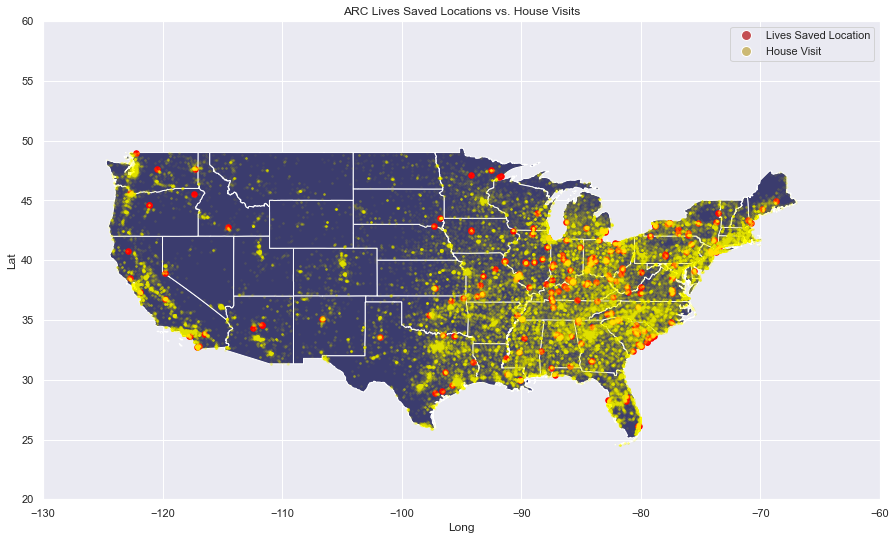

In [3]:
# Create map visualization of ARC lives saved locations & house visits within continental US

# Create geopandas dataframes based on long(x)/lat(y) locations within ARC data
geometry_lives_saved = [Point(xy) for xy in zip(lives_saved['Census Block Group X'],
                                                lives_saved['Census Block Group Y'])]
geometry_visits = [Point(xy) for xy in zip(arc_visits['Census Block Group X'],
                                           arc_visits['Census Block Group Y'])]
gdf_lives_saved = geopandas.GeoDataFrame(lives_saved, geometry=geometry_lives_saved)
gdf_visits = geopandas.GeoDataFrame(arc_visits, geometry=geometry_visits)

# Import country map
country_data_path = data_path / "gz_2010_us_040_00_5m.json"
country = geopandas.read_file(country_data_path)

# Set figure parameters
fig, ax = plt.subplots(1, figsize=(15,20))
plt.xlim(-130, -60)
plt.ylim(20,60)
plt.title('ARC Lives Saved Locations vs. House Visits')
plt.xlabel('Long')
plt.ylabel('Lat')

# Plot geopandas dataframes on country map; each ".plot" represents a single layer within the visualization
base = country[country['NAME'].isin(['Alaska','Hawaii']) == False].plot(ax=ax, color='#3B3C6E')
gdf_lives_saved.plot(ax=base, color='red', marker="o", markersize=30);
gdf_visits.plot(ax=base, color='yellow', marker="o", markersize=3, alpha=0.03);

# Create custom legend for visualization
legend_elements = [Line2D([0], [0], marker='o', color='w', lw=0, label='Lives Saved Location',
                          markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker='o', color='w', lw=0, label='House Visit',
                          markerfacecolor='y', markersize=10)]
ax.legend(handles=legend_elements, loc='upper right')


In [4]:
# ACS Munging

# Ensures GEOID variable is in the correct format and sets it as the dataframe index
ACS['GEOID'] = ACS['GEOID'].str[2:]   
ACS.set_index(['GEOID'],inplace = True)

# Captures name properies of GEOIDs for later use before filtering dataframe to be numeric features only
Names = ACS[['county_name', 'state_name']]

# Removes extraneous features (i.e. non-numeric) in the dataframe
if 'Unnamed: 0' in ACS.columns:
    ACS.drop('Unnamed: 0','columns',inplace= True)

if 'NAME' in ACS.columns:
    ACS.drop('NAME','columns',inplace= True)

if 'inc_pcincome' in ACS.columns:
    ACS.drop('inc_pcincome','columns',inplace= True)

# Creates vector of total populations for each census block to be used to normalize total fires per year variable
tot_pop = ACS[['tot_population']]

# Drop all total count columns in ACS and keeps all percentage columns
cols = ACS.columns.to_list()
for col in cols:
    if  col.find('tot') != -1 : 
        ACS.drop(col,'columns', inplace = True)


# Integer indexing for all rows, but gets rid of county_name, state_name, and in_poverty
ACS = ACS.iloc[:,3:]

# Remove missing values from dataframe
ACS.replace([np.inf, -np.inf], np.nan,inplace = True)
ACS.dropna(inplace = True)


<ipython-input-27-1d8da3e7e1f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lives_saved_geoid['GEOID'] = lives_saved_geoid['GEOID'].str[2:]


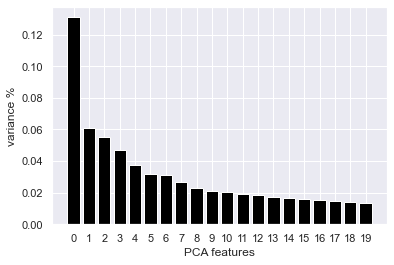

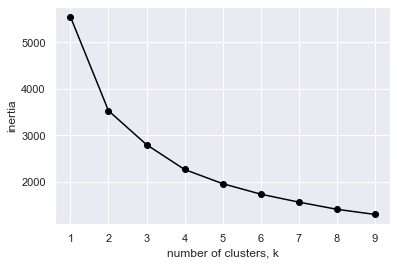

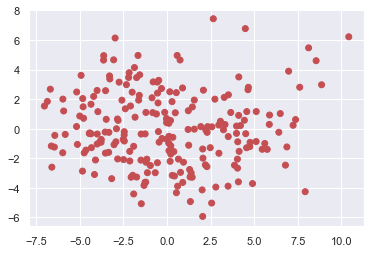

<ipython-input-27-1d8da3e7e1f1>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_lives_saved_ACS['dist_from_centroid'] = dist.T


                    county_name      state_name
GEOID                                          
131590105004      Jasper County         Georgia
220170249002       Caddo Parish       Louisiana
281079502002      Panola County     Mississippi
370850703001     Harnett County  North Carolina
370850705002     Harnett County  North Carolina
371570408001  Rockingham County  North Carolina
470339613002    Crockett County       Tennessee
481599502001    Franklin County           Texas
483499706004     Navarro County           Texas
484230021013       Smith County           Texas


In [27]:
# Find similar census blocks to those where ARC saved lives 

# Capture ACS features for GEOIDs of lives saved locations
lives_saved_geoid = lives_saved[['GEOID']]
lives_saved_geoid['GEOID'] = lives_saved_geoid['GEOID'].str[2:]  
lives_saved_ACS = ACS[ACS.index.isin(lives_saved_geoid['GEOID'].tolist())]
not_lives_saved_ACS = ACS[~ACS.index.isin(lives_saved_geoid['GEOID'].tolist())]

# Calculates distance matrix between lives saved locations
# Helps to answer whether lives saved locations are similar in nature
#pairwise = pd.DataFrame(squareform(pdist(lives_saved_ACS)),columns = lives_saved_ACS.index,index = lives_saved_ACS.index)

# Standardize the data to have a mean of ~0 and a variance of 1
X_std = preprocessing.StandardScaler().fit_transform(lives_saved_ACS)

# Capture PCA components of lives saved data in order to create bar graph showing explained variance of each component
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

# Save PCA components to a DataFrame in order to generate an inertia plot that helps decide the number of clusters
# The elbow of this line graph typically represents the best number of clusters to use in k-means
PCA_components = pd.DataFrame(principalComponents)
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

# Based on the above graph's elbow at k clusters, perform k-means clustering and calculate cluster centroids
# After viewing the original plot w/ 2 clusters, I decided that the data points can easily fall into 1 cluster
# This will make it a lot easier to compare the lives saved locations to other census blocks
kmeans = KMeans(n_clusters=1).fit(lives_saved_ACS)
centroids = kmeans.cluster_centers_

# Plot your multi-dimensional data points in k-designated clusters by leveraging the PCA components
pl.figure('K-means with 1 clusters')
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'k'}
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
pl.scatter(principalComponents[:, 0], principalComponents[:, 1], c=label_color)
pl.show()

# Calculate distances between lives saved cluster centroid and all other census blocks
dist = pairwise.pairwise_distances(centroids, not_lives_saved_ACS)
not_lives_saved_ACS['dist_from_centroid'] = dist.T

# Get top 10 closest census blocks to cluser centroid
# I'd like to be able to capture the long/lat coordinates of these geoids but they aren't available in our current datasets
similar_blocks = not_lives_saved_ACS[not_lives_saved_ACS['dist_from_centroid']<0.463]
potential_lives_saved = Names[Names.index.isin(similar_blocks.index.tolist())]
print (potential_lives_saved)
